#### TOC
1. Anomalies in Data, and cleaning action & explaination. 15 pts
2. Pairwise Corralation Table and explaition. 10 pts
3. Average records stockID vs Day, 25 pts
    - a. autocorrelation, 10 pts
    - b. measure the distance, 5 pts
    - c. clustering algorithm, 10 pts
4. Closing trajectory of stocks on each day highly correlated, 25 pts
   - a. Make three plots, 10 pts
   - b. permutation test to determine the statistical confidence, 15 pts
      p-value
5. Best prediction model, any approaches, 25 pts
6. submit model on Kaggle, 0 pts

#### Start
- Copy this notebook.
  In Google Colab use `File -> Save a Copy in Drive`.
- Use the "Text" blocks to provide explanations wherever you find them necessary.
- Highlight your answers inside these text fields to ensure that we don't miss it
while grading your HW.

#### Setup

- Code to download the data directly from the colab notebook.
- If you find it easier to download the data from the kaggle website (and
uploading it to your drive), you can skip this section.

In [6]:
## packages
!pip install -q kaggle
!pip install -q pandas
!pip install -q scikit-learn
!pip install -q numpy
!pip install -q Matplotlib
!pip install -q seaborn


In [7]:
## Upload the file by clicking on the browse
from google.colab import files
files.upload()

## Create a new API token under "Account" in the kaggle webpage and download the json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aditivijaykulkarni","key":"8b1a498f4da2b10723fa3ea7cf8d8ae3"}'}

In [8]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c optiver-trading-at-the-close
!unzip optiver-trading-at-the-close.zip
!ls

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 94% 188M/201M [00:01<00:00, 215MB/s]
100% 201M/201M [00:01<00:00, 179MB/s]
Archive:  optiver-trading-at-the-close.zip
  inflating: example_test_files/revealed_targets.csv  
  inflating: example_test_files/sample_submission.csv  
  inflating: example_test_files/test.csv  
  inflating: optiver2023/__init__.py  
  inflating: optiver2023/competition.cpython-310-x86_64-linux-gnu.so  
  inflating: public_timeseries_testing_util.py  
  inflating: train.csv               
example_test_files  optiver2023			      public_timeseries_testing_util.py  train.csv
kaggle.json	    optiver-trading-at-the-close.zip  sample_data


#### Q1: Anomalies and Cleaning, 15 pts


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

col_names = [
  "stock_id",                   # unique identifier for the stock
  "date_id",                    # unique identifier for the date. Date IDs are sequential & consistent across all stocks.
  "seconds_in_bucket",          # number of seconds elapsed since the beginning of the day's closing auction, always starting from 0
  "imbalance_size",             # imbalance between buy and sell orders
  "imbalance_buy_sell_flag",    # 1 for a buy-side imbalance, -1 for a sell-side imbalance, and 0 for no imbalance
  "reference_price",            # price at which paired shares are maximized, the imbalance between buy and sell orders is minimized, and the distance from the bid-ask midpoint is minimized
  "matched_size",               # how many shares can be exchanged at the reference price
  "far_price",                  # reference price to determine how "far" the closing price is from earlier trading activity
  "near_price",                 # reference price used to gauge the stock's behavior as it approaches the closing auction.
  "bid_price",                  # highest price at which a buyer is willing to purchase a stock
  "bid_size",                   # number of shares ready to sell
  "ask_price",                  # price at which sellers are willing to sell a stock
  "ask_size",                   # number of shares ready to buy
  "wap",                        # avg price
  "target",                     # 60-second future move in the wap of the stock, less the 60-second future move of the synthetic index.
  "time_id",                    # sequential indicator for the time buckets
  "row_id"                      # unique string f"{date_id}_{time_in_bucket}_{row_id}"
]
dtypes = {
  "stock_id": np.int,
  "date_id":np.int,
  "seconds_in_bucket":np.int,
  "imbalance_size":np.float64,
  "imbalance_buy_sell_flag":np.int,
  "reference_price":np.float64,
  "matched_size":np.float64,
  "far_price":np.float64,
  "near_price":np.float64,
  "bid_price":np.float64,
  "bid_size":np.float64,
  "ask_price":np.float64,
  "ask_size":np.float64,
  "wap":np.float64,
  "target":np.float64,
  "time_id":np.int,
  "row_id": "string",
}
csv = pd.read_csv("train.csv")

<ipython-input-4-5d9fa4656145>:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "stock_id": np.int,
<ipython-input-4-5d9fa4656145>:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and

In [6]:
# Calling shape to check the number of rows and columns
csv.shape

(5237980, 17)

In [7]:
csv.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [8]:
# Take a look at the training data. There may be anomalies in the data that you may need to factor in before you start on the other tasks.
# Make a note of the anomalies that you notice. Clean the data first to handle these issues if it will improve your analysis.
# Explain what you did to clean the data (in bulleted form) or explain why you did not change it to address these anomalies. (15 points)

columns_with_missing_data = csv.columns[csv.isnull().any()].tolist()

# Display the list of columns with missing data
print("Columns with missing data:")
for col in columns_with_missing_data:
    print(col)

Columns with missing data:
imbalance_size
reference_price
matched_size
far_price
near_price
bid_price
ask_price
wap
target


Above are the columns with missing values. From these -
1.   Imbalance_size
2.   reference_price
3.   matched_size
4.   far_price
5.   near_price
6.   bid_price
7.   ask_price
8.   wap
9.   target

In [14]:
# List of columns you want to check for NaN values
selected_columns_with_null_values = ['imbalance_size', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'ask_price', 'wap', 'target']

# Remove rows where all selected columns are NaN
csv = csv.dropna(subset=selected_columns_with_null_values, how='all')

csv.shape

(5237892, 17)

*   We removed 88 rows with NaN values in 'imbalance_size', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'ask_price', 'wap' and 'target' as they weren't adding any value to the dataframe.

In [15]:
csv['far_price'].ffill(inplace=True)
csv['near_price'].ffill(inplace=True)

csv['far_price'].bfill(inplace=True)
csv['near_price'].bfill(inplace=True)

*   Far_price and near_price have most amount of null values as NASDAC has these values post 300 seconds_in_bucket.
*   However, on trying to find correlation/average/distance with uncleaned data, I was getting misleading results due to NaN values.
*   So, Stock time series data is backfilled or forward-filled for missing values to ensure that data remains continuous.

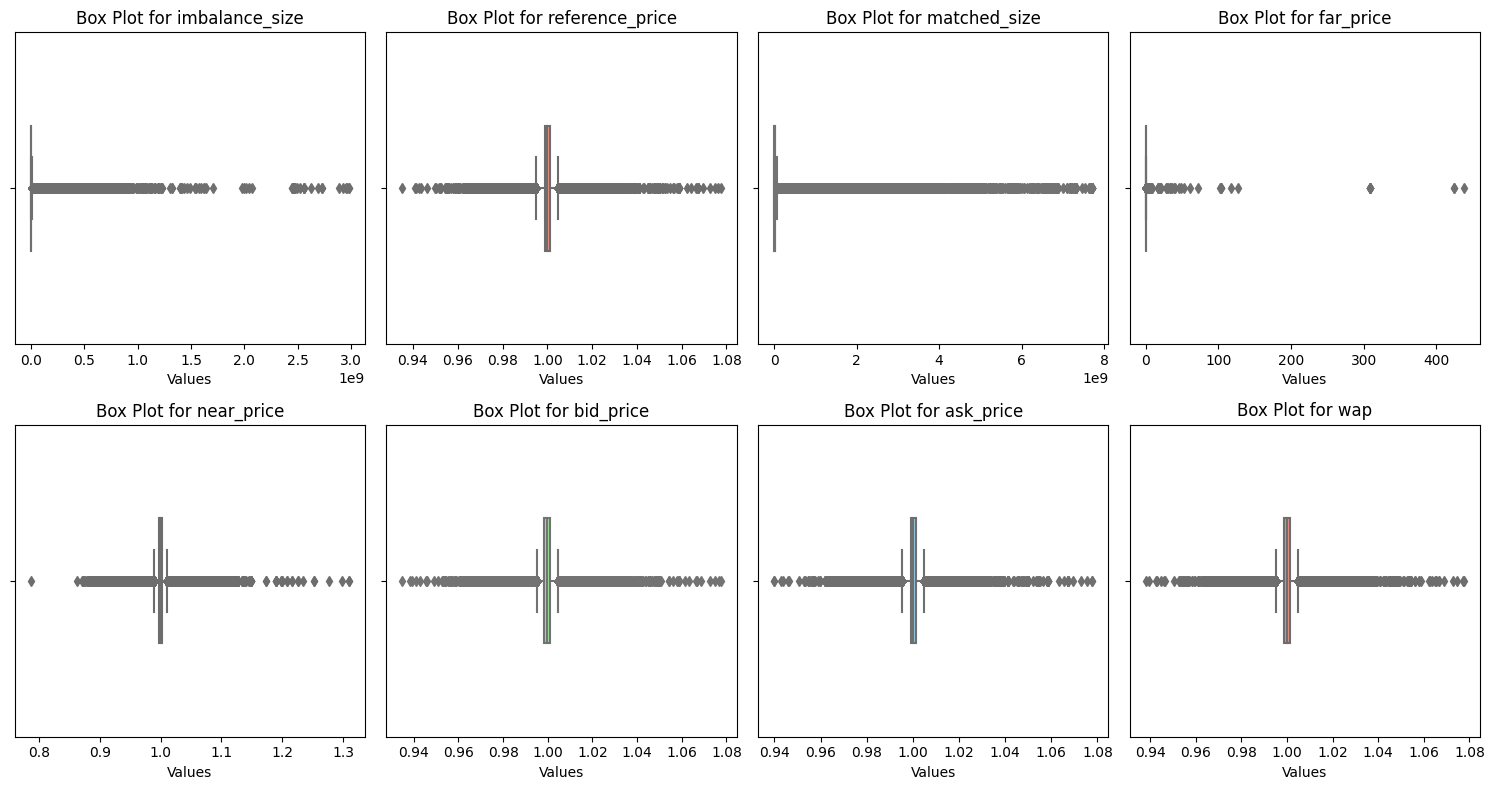

In [16]:
columns_to_plot = ['imbalance_size', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'ask_price', 'wap']

num_subplots_per_row = 4
num_rows = (len(columns_to_plot) + num_subplots_per_row - 1) // num_subplots_per_row

fig, axes = plt.subplots(num_rows, num_subplots_per_row, figsize=(15, 4 * num_rows))

# Define colors for the box plots
colors = ['skyblue', 'salmon', 'lightgreen']

for i, column in enumerate(columns_to_plot):
    row_index = i // num_subplots_per_row
    col_index = i % num_subplots_per_row
    ax = axes[row_index, col_index]
    sns.boxplot(x=csv[column], color=colors[i % 3], width=0.4, ax=ax)
    ax.set_title(f'Box Plot for {column}')
    ax.set_xlabel('Values')

for i in range(len(columns_to_plot), num_subplots_per_row * num_rows):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


* From the above box plots, we notice that only far_price and near_price have extreme outliers.
* Other columns don't seem to have such outliers.

#### Q2: Pairwise Corralation Table and Explaition. 10 pts


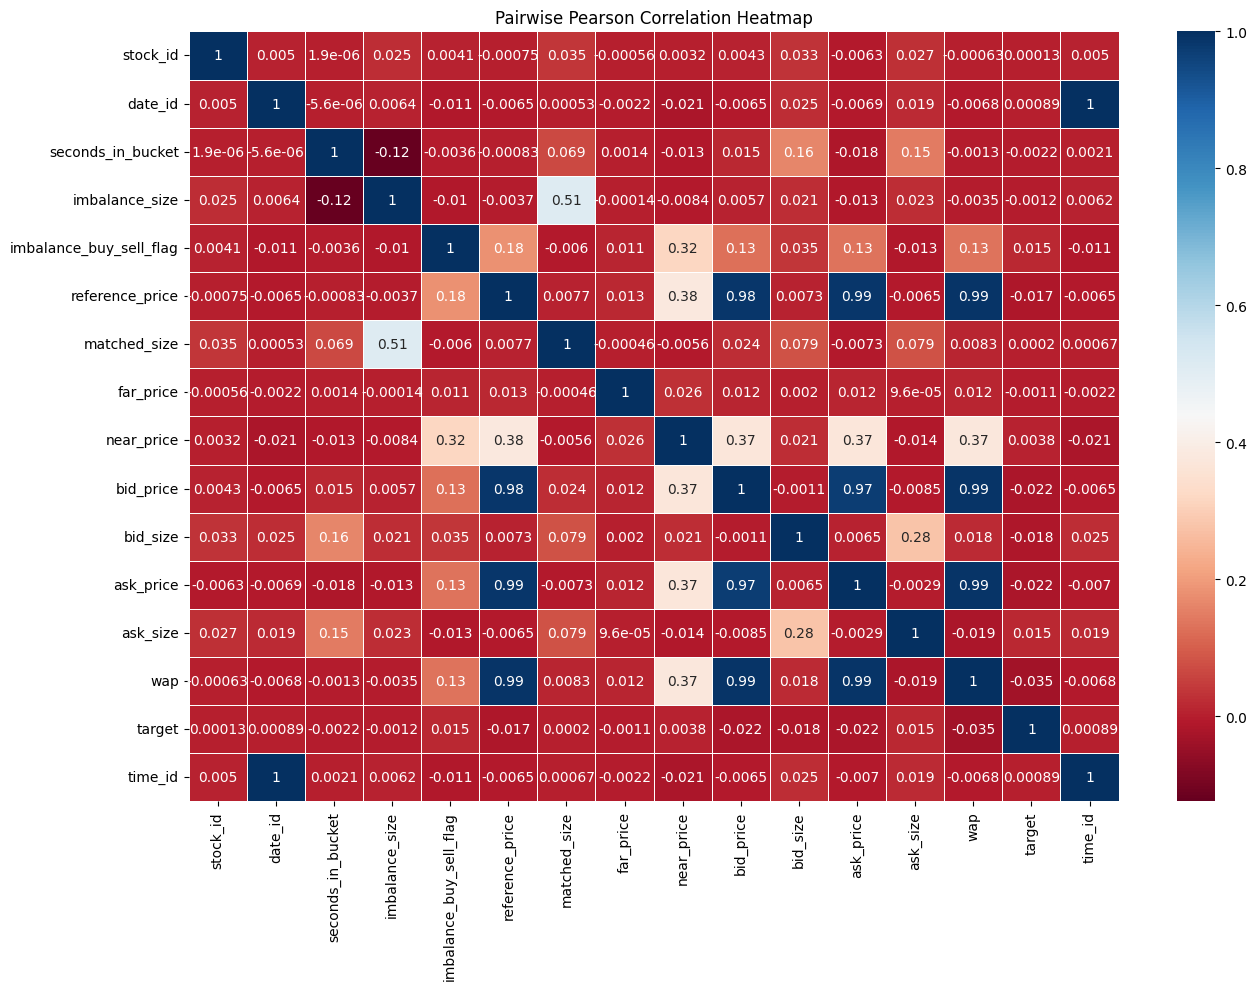

In [12]:
# Construct a pairwise correlation table of the given variables.  Use Pearson correlation.
# For pairs of variables with high absolute correlations, explain why they are so highly correlated.

# Calculate the Pearson correlation matrix
correlation_matrix = csv[['stock_id','date_id','seconds_in_bucket','imbalance_size','imbalance_buy_sell_flag','reference_price','matched_size','far_price',
                          'near_price','bid_price','bid_size','ask_price','ask_size','wap','target','time_id']].corr(method='pearson')

# Create a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', linewidths=0.5)
plt.title('Pairwise Pearson Correlation Heatmap')
plt.show()


Below are the pairs that are highly correlated -
*   Bid Price - Reference Price -> These variables are highly correlated because the bid price represents the maximum price a buyer is willing to pay, and the reference price is a baseline for the stock's value. So, the bid price tends to be closer to the reference price in an efficient market.
*   Ask Price - Reference Price -> Same as bid price. Ask price represents the minimum price a seller is willing to accept for a stock, and in an efficient market, it will go up and down with reference price.
*   WAP - Reference Price -> Weighted average price is calculated using bid price and ask price, so if the values of bid price and ask price go up, WAP will also go up, hence the strong positive corelation.
*  Similarly, Ask Price - Bid Price, Ask Price - Wap, Bid Price - WAP are correlated to each other for the above mentioned reasons.



#### Q3: Average records stockID vs Day, 25 pts
distance function between entries
- a. autocorrelation, 10 pts
- b. measure the distance, 5 pts
- c. clustering algorithm, 10 pts



In [13]:
from numpy.ma.extras import average
# Define an “average” or “consensus” record for each stock id s on a particular day d, measuring how the stock s performs on day d’s close.
# Then define a distance function between pairs of “stock-day” distance records, measuring how similarly they are.

df_with_average = csv.groupby(['stock_id','date_id'])[['far_price','near_price','ask_price','bid_price']].mean()
df_with_average.reset_index(inplace=True)
df_with_average['average'] = df_with_average[['far_price', 'near_price', 'ask_price', 'bid_price']].mean(axis=1)
df_with_average = df_with_average[['stock_id', 'date_id', 'average']]

df_with_average.head()

,stock_id,date_id,average
0,0,0,0.999798
1,0,1,1.000951
2,0,2,0.999235
3,0,3,0.991797
4,0,4,0.997425


* Here, I am considering typical price of a stock as average.
* In financial trading, typical price refers to the arithmetic average of the high, low, and closing prices for a given period. In our dataset,
* I am calculating the average price of a stock on a particular day by taking mean of 'far_price', 'near_price', 'ask_price',' bid_price'.
* Firstly, I have created a new dataframe by grouping date id and stock id considering the mean of above mentioned 4 columns.
* Then I have taken a mean of these columns again and save it in a new column 'average'.
* Other 4 columns have been dropped.



In [14]:
# For each stock, measure the autocorrelation of the average distance between day i and day i+k for -10 <= k <= +10.
# On average (over all stocks), is there a statistically significant degree of autocorrelation in the market?
# Present your evidence for or against? Are there particular stocks whose performance is unusually autocorrelated,
# in a statistically significant way? (10 points)

df_with_average['average'] = df_with_average.groupby('stock_id')['average'].ffill().bfill()

def calculate_difference(series):
    differences = series.diff()
    differences.iloc[0] = 0
    # euclidean_distance = np.linalg.norm(differences.fillna(0).astype(float))
    return differences

def calculate_auto_corr(series, lag):
    return series.rolling(lag).apply(lambda x: pd.Series(x).autocorr())

# Calculate Euclidean distance for 'average' column
df_with_average['difference'] = df_with_average.groupby('stock_id', group_keys=False)['average'].transform(calculate_difference)

# Group the DataFrame by 'stock' and apply the function to each group
for lag in range(3,22,2):
  result_column = f'auto_corr_{lag}'  # Create a column name for the results
  df_with_average[result_column] = df_with_average.groupby('stock_id', group_keys=False)['difference'].apply(calculate_auto_corr, lag=lag)

df_with_average.reset_index(drop=True, inplace=True)

df_with_average.head(1000)


,stock_id,date_id,average,difference,auto_corr_3,auto_corr_5,auto_corr_7,auto_corr_9,auto_corr_11,auto_corr_13,auto_corr_15,auto_corr_17,auto_corr_19,auto_corr_21
0,0,0,0.999798,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,1.000951,0.001153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,0.999235,-0.001716,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,3,0.991797,-0.007438,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,4,0.997425,0.005628,-1.0,-0.572371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2,33,0.986983,-0.010755,1.0,0.136362,0.206913,0.169203,0.102154,0.032292,0.003572,-0.063402,-0.232868,-0.226804
996,2,34,1.002425,0.015442,-1.0,-0.709945,-0.721641,-0.560597,-0.541306,-0.524768,-0.518276,-0.517887,-0.552709,-0.547472
997,2,35,0.999004,-0.003421,-1.0,-0.500349,-0.497066,-0.485904,-0.478381,-0.463966,-0.461390,-0.465864,-0.461455,-0.498642
998,2,36,1.001196,0.002191,-1.0,-0.512753,-0.508533,-0.517306,-0.480498,-0.460693,-0.474247,-0.471505,-0.474529,-0.506369


Explanation -
*   Here, I am using rolling function of pandas to move over the series and calculate autocorrelation.
*   I am considering window size to be 3,5,7 and so on as to factor in negative values.
*   Autocorrelation is being calculated of the differences between averages for each stock id and date id pair.

In [15]:
auto_corr_columns = [f'auto_corr_{lag}' for lag in range(3,22,2)]

# Group the DataFrame by 'stock_id' and calculate the mean autocorrelation values for each group
mean_autocorr_values = df_with_average.groupby('stock_id')[auto_corr_columns].mean()

max_mean_lag = mean_autocorr_values.idxmax()
highest_mean_autocorr = mean_autocorr_values.max()

print("Mean Autocorrelation Values:")
print(mean_autocorr_values)

Mean Autocorrelation Values:
          auto_corr_3  auto_corr_5  auto_corr_7  auto_corr_9  auto_corr_11  \
stock_id                                                                     
0           -0.423800    -0.402076    -0.383598    -0.391471     -0.399310   
1           -0.432150    -0.447674    -0.436195    -0.434141     -0.436849   
2           -0.482255    -0.471722    -0.454232    -0.457930     -0.466200   
3           -0.440501    -0.442171    -0.435485    -0.441289     -0.447558   
4           -0.448852    -0.454002    -0.451571    -0.451969     -0.455189   
...               ...          ...          ...          ...           ...   
195         -0.407098    -0.395800    -0.370077    -0.365375     -0.369663   
196         -0.478079    -0.429604    -0.415053    -0.420860     -0.429160   
197         -0.453027    -0.416153    -0.399523    -0.403880     -0.415611   
198         -0.390397    -0.407082    -0.382857    -0.372089     -0.372573   
199         -0.442455    -0.391098 

As per the results -
*   The correlation is maximum when we consider lag as 3 i.e -1, itself and +1 which is as expected.
*   The correlation goes on decreasing as we move further away and increase the lag.
*   This translates to - the stock prices of tomorrow and the day before today are likely to have impacted each other whereas there's little correlation for lag say 10.



In [16]:
# For each pair of stocks a and b, measure the distance between a on day i and b on day i for every day i. Are there pairs of stocks which are
# unusually similar on a consistent basis?  If a for-loop proves too slow, investigate broadcastable numpy/pandas operations. (5 points)

pivot_df = df_with_average.pivot(index='date_id', columns='stock_id', values='average')

# pivot_df.head()

correlation_matrix = pivot_df.corr()

rolling_corr_df = pd.DataFrame(index=correlation_matrix.columns, columns=correlation_matrix.columns)
window_size = 20
for stock_a in correlation_matrix.columns:
    for stock_b in correlation_matrix.columns:
        if stock_a != stock_b:
            rolling_corr = pivot_df[stock_a].rolling(window=window_size).corr(pivot_df[stock_b])
            rolling_corr_df.at[stock_a, stock_b] = rolling_corr

threshold = 0.9
unusually_similar_pairs = [(stock_a, stock_b) for stock_a in rolling_corr_df.columns for stock_b in rolling_corr_df.columns if stock_a != stock_b and rolling_corr_df.at[stock_a, stock_b].max() > threshold]

print(unusually_similar_pairs)


[(3, 13), (3, 198), (7, 17), (7, 23), (7, 27), (7, 41), (7, 45), (7, 95), (7, 110), (7, 126), (7, 140), (7, 141), (7, 142), (9, 112), (11, 162), (12, 123), (13, 3), (13, 17), (13, 72), (13, 87), (13, 97), (13, 142), (13, 183), (14, 45), (14, 133), (14, 184), (17, 7), (17, 13), (17, 41), (17, 72), (17, 87), (17, 96), (17, 126), (17, 140), (17, 141), (17, 183), (22, 23), (22, 27), (22, 83), (22, 87), (22, 141), (22, 183), (23, 7), (23, 22), (23, 27), (23, 72), (23, 83), (23, 89), (23, 141), (23, 142), (23, 162), (23, 183), (26, 49), (27, 7), (27, 22), (27, 23), (27, 72), (27, 142), (27, 183), (31, 197), (32, 175), (34, 41), (34, 142), (34, 175), (35, 105), (38, 187), (39, 110), (41, 7), (41, 17), (41, 34), (41, 45), (41, 84), (41, 95), (41, 126), (41, 130), (41, 140), (41, 141), (41, 142), (41, 151), (41, 179), (41, 191), (45, 7), (45, 14), (45, 41), (45, 58), (45, 77), (45, 83), (45, 84), (45, 96), (45, 112), (45, 130), (45, 140), (45, 141), (45, 142), (45, 160), (45, 163), (45, 171), (

In the above question -
*   I have first pivoted the dataframe to get stock_id as columns and date_id as rows. The values in this matrix are average of each stock for that day.
*   Then, I have calculated the correlation between each column using Pearsons Correlation.
*   In order to check the number of pairs having higher correlation, say, 0.9+, I am looping over corrleation matrix.
*   Around 204 pairs have higher correlation. This translates to - if stock a increases/decreases - stock b will mostly increase/decrease too.
*   In real world, this is possible when two stocks are from same industry.
*   Window size is 20 for now, that is trends are being checked for 20 days, more like short term trends. It can be increased to a higher number if we want to check the consistent correlation between two stocks for longer duration.

In [17]:
# Construct one “average” or “consensus” record for each stock. Now cluster the stocks using a clustering algorithm like k-means.
# How many big clusters do you find?  Create a TSNE-plot of the stocks where you color each stock according to its cluster ID.
# Do the colors seem visually coherent to you or not? (10 points)
from sklearn.cluster import KMeans

result = csv.groupby('stock_id')[['far_price','near_price', 'ask_price', 'bid_price']].mean().reset_index()
# result.head()

k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
result['cluster'] = kmeans.fit_predict(result[['far_price','near_price', 'ask_price', 'bid_price']])

# print(result)

cluster_counts = result.groupby('cluster').size().reset_index(name='count')

print(cluster_counts)

   cluster  count
0        0     31
1        1      2
2        2    167



*   I have taken 3 k-means clusters as per the elbow method.
*   2 big clusters are observed and 1 small cluster.



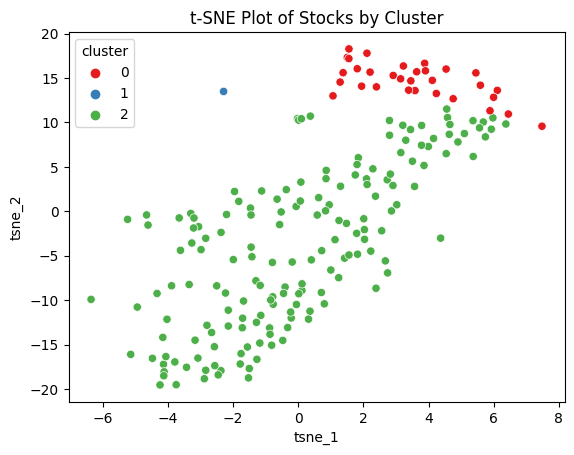

In [19]:
# Create a TSNE model with 2 components (you can adjust the number of components)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)

# Fit and transform the data to reduce it to 2 dimensions
tsne_result = tsne.fit_transform(result[['far_price','near_price', 'ask_price', 'bid_price']])

# Add the t-SNE results to the DataFrame
result['tsne_1'] = tsne_result[:, 0]
result['tsne_2'] = tsne_result[:, 1]

# Optional: You can use Seaborn for better visualization
sns.scatterplot(x='tsne_1', y='tsne_2', hue='cluster', data=result, palette='Set1')
plt.title("t-SNE Plot of Stocks by Cluster")
plt.show()

Observation -
*   The colors (representing clusters) appear to be grouped together, indicating that the clustering algorithm has successfully separated the stocks into meaningful groups.
*   The goal of this analysis is to understand how stocks naturally group together based on their average attributes and assess the quality of the clustering results by visualizing them with t-SNE and evaluating their coherence.
*   If the colors would have been scattered or mixed, it may indicate that the clustering was less successful in capturing underlying patterns in the data.
*    In real world, coherent clusters could indicate that stocks within the same sector or industry tend to have similar average attributes. For example, visually coherent clusters might represent technology stocks, financial stocks, healthcare stocks, etc., forming distinct groups.





#### Q4: Closing trajectory of stocks on each day highly correlated, 25 pts
- a. Make three plots, 10 pts
- b. permutation test for statistical confidence, p-value, 15 pts


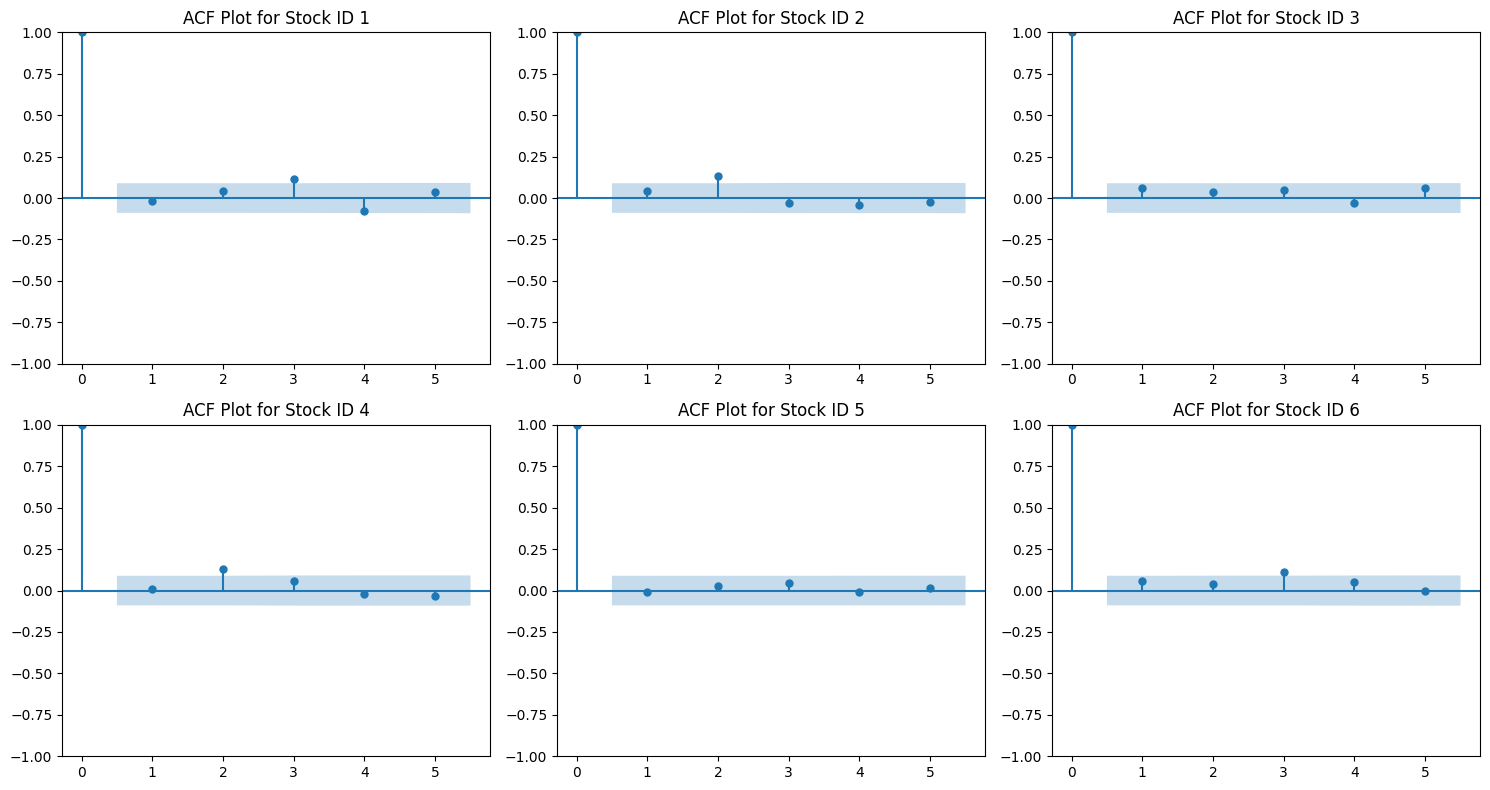

In [9]:
# Is the closing trajectory of stocks on each day highly correlated (“there are up days and down days in the market”) or is it essentially random
# (say, “supply and demand cause distinct fluctuations on individual stocks each day”)?
# Make three plots that convince you of which is the right answer, and will convince me as well.  If there is a formal statistical test to help
# you do this, do it. (10 points)
from statsmodels.graphics.tsaplots import plot_acf

df_for_plotting = csv[csv['seconds_in_bucket'] == 540].groupby('stock_id')

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

for stock_id in range(1, 7):
    row = (stock_id - 1) // 3
    col = (stock_id - 1) % 3

    ax = axes[row, col]

    group = df_for_plotting.get_group(stock_id)

    plot_acf(group['reference_price'], lags=5, ax=ax)
    ax.set_title(f'ACF Plot for Stock ID {stock_id}')

plt.tight_layout()
plt.show()

*   Considering reference_price at 540 seconds for each day as closing price because 540th second is the last observed second_in_bucket.
*   ACF graph shows that the market is fluctuating and the closing price is not really correlated to each other.

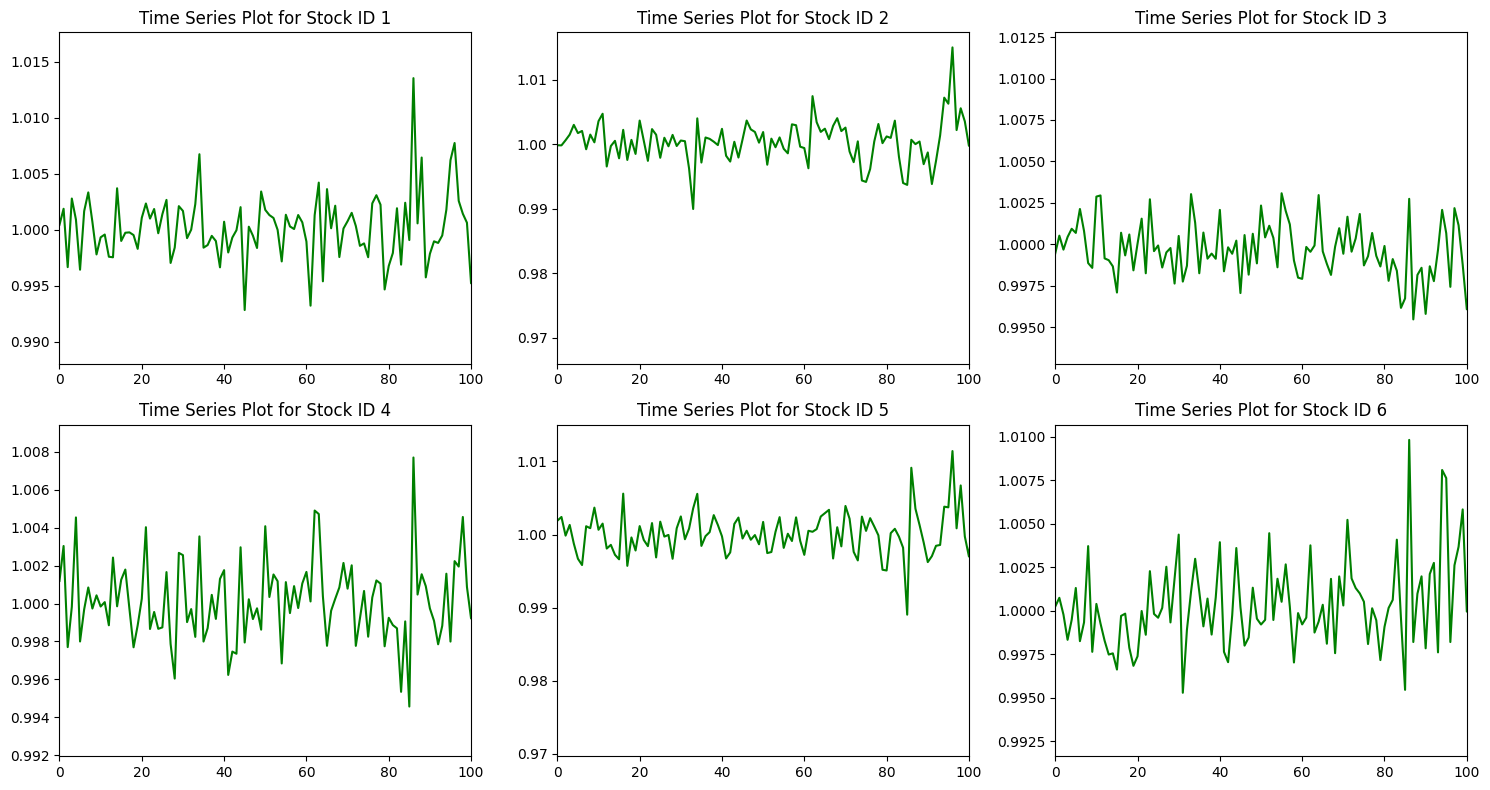

In [10]:
# Create a subplot with 2 rows and 3 columns for time series plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

for stock_id in range(1, 7):
    row = (stock_id - 1) // 3
    col = (stock_id - 1) % 3

    ax = axes[row, col]
    group = df_for_plotting.get_group(stock_id)
    ax.plot(group['date_id'], group['reference_price'], color='green')
    ax.set_title(f'Time Series Plot for Stock ID {stock_id}')
    ax.set_xlim(0, 100)  # Adjust the x-scale

# Adjust the layout and display the time series plots
plt.tight_layout()
plt.show()

*   We have plotted reference price at 540th second vs date_id graph for first 6 stocks as an example.
*   Above time series plot suggests that there is no direct correlation between closing prices as we can see the prices are fluctuating.

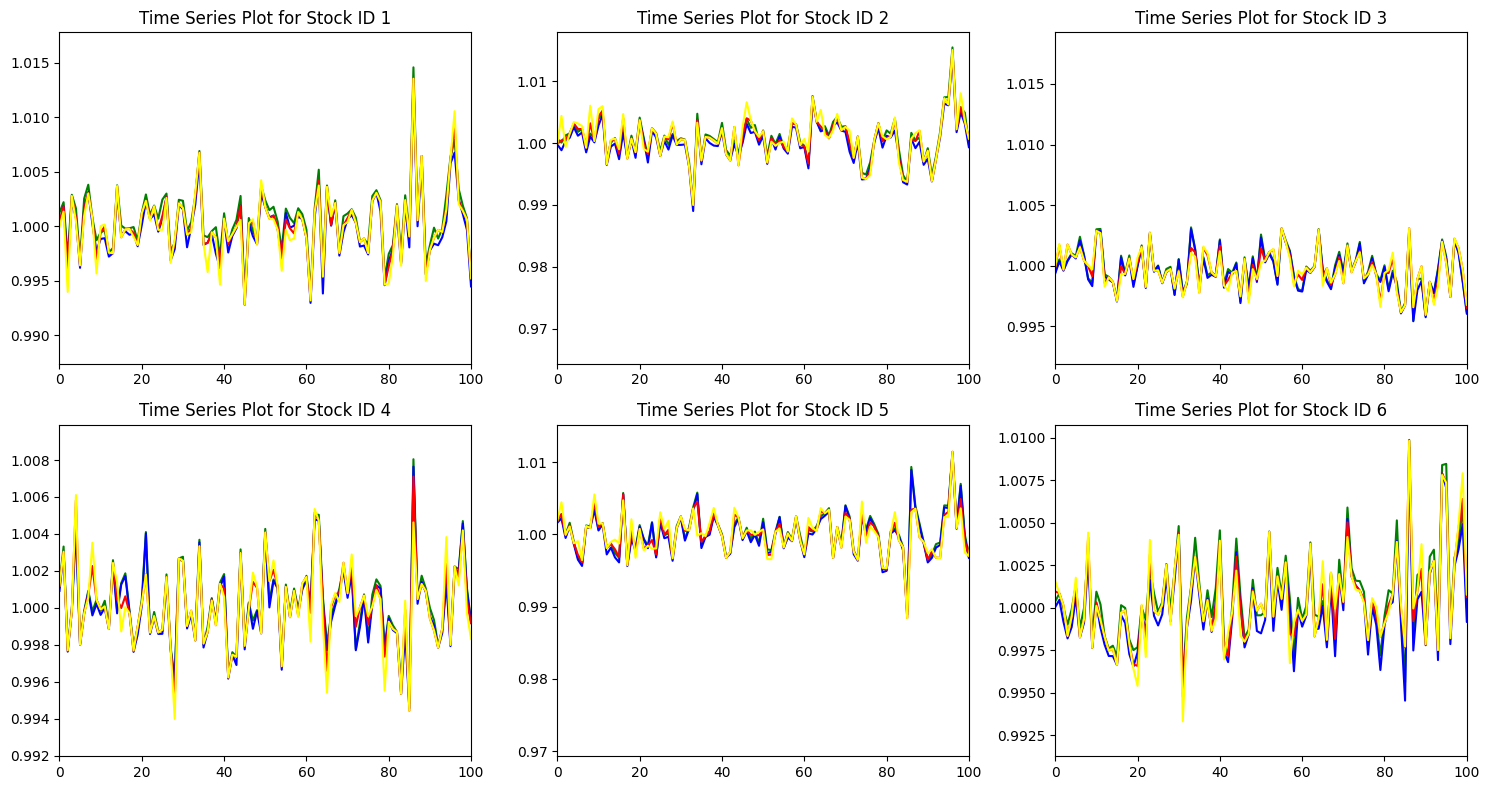

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

for stock_id in range(1, 7):
    row = (stock_id - 1) // 3
    col = (stock_id - 1) % 3

    ax = axes[row, col]
    group = df_for_plotting.get_group(stock_id)
    ax.plot(group['date_id'], group['ask_price'], color='green')
    ax.plot(group['date_id'], group['bid_price'], color='blue')
    ax.plot(group['date_id'], group['near_price'], color='red')
    ax.plot(group['date_id'], group['far_price'], color='yellow')
    ax.set_title(f'Time Series Plot for Stock ID {stock_id}')
    ax.set_xlim(0, 100)

plt.tight_layout()
plt.show()

* The graph above supports the same result we got above. The four values plot above drive the closing price of a stock.  
* Since they have tremendous fluctuation, it is difficult to say the price would be corrleated.

<ipython-input-12-6ec7076d5a0d>:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(15, 3))


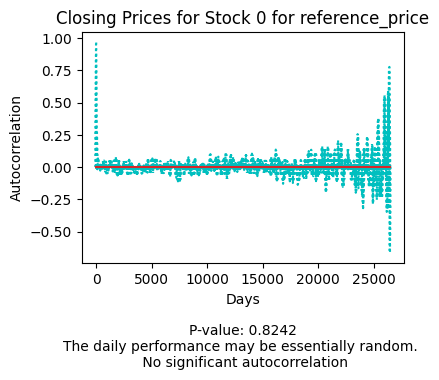

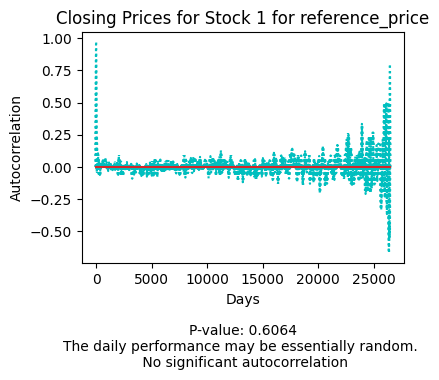

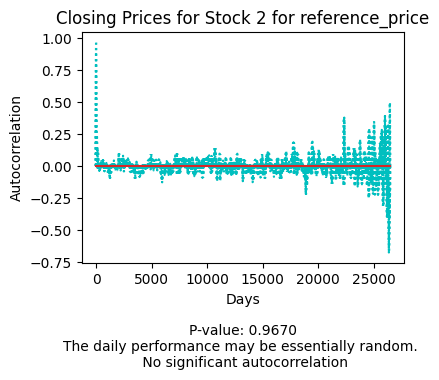

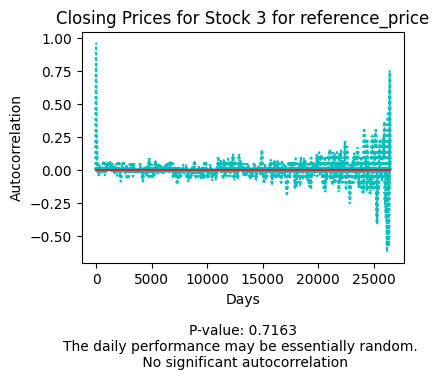

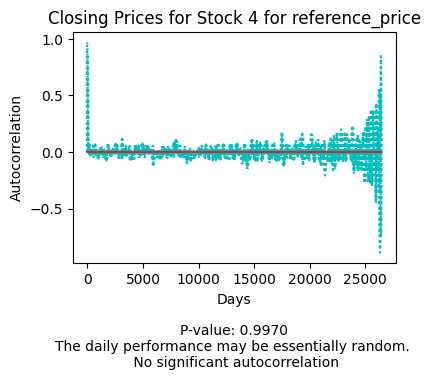

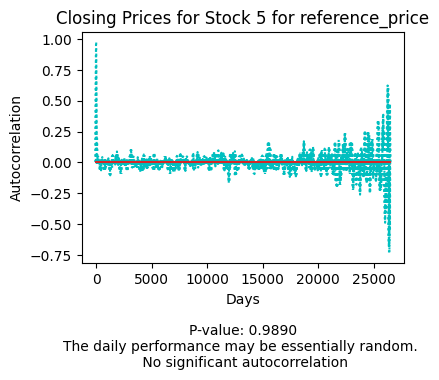

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

In [12]:
# Perform a permutation test to determine the statistical confidence that you believe your answer.  In particular, for each stock randomly permute
# the day index to construct an artificial time series for it.   Now measure the consistency of daily performance in this permuted data set.
# Run enough permutations per variable to establish a p-value of how confident you are in your conclusion  (15 points)
import matplotlib.gridspec as gridspec

columns = ['reference_price']


# Permutation test to assess the statistical significance
def permutation_test(original_data, num_permutations=1000):
  def test_statistic(data):
    return np.mean(data)
  observed_statistic = test_statistic(original_data)
  permuted_statistics = np.zeros(num_permutations)
  for i in range(num_permutations):
    shuffled_data = np.random.permutation(original_data)
    permuted_statistics[i] = test_statistic(shuffled_data)


  p_value = (np.sum(permuted_statistics >= observed_statistic) + 1) / (num_permutations + 1)
  return p_value

plot_counter = 0

for stock_id in csv['stock_id'].unique():
  stock_data = csv[csv['stock_id'] == stock_id]
  rangeVal = stock_data.shape[0]-20


  # Number of plots
  num_plots = len(columns)


  # Set the number of rows and columns for the subplots
  num_rows = 1 # 2 rows
  num_cols = 3 # 2 columns


  # Create a figure with subplots
  fig = plt.figure(figsize=(15, 3))


  gs = gridspec.GridSpec(num_rows, num_cols, wspace=0.4, hspace=0.4)


  # Adjust the gap between rows and columns
  gs.update(wspace=0.3, hspace=0.7)


  # Loop through the data and plot each dataset
  colors=['c:','g:','b:']


  for j in range(num_plots):
    if plot_counter >= 6:
      break
    ax = fig.add_subplot(gs[j])
    autocorr = [np.corrcoef(stock_data[columns[j]][:-i], stock_data[columns[j]][i:])[0, 1] for i in range(1, rangeVal)]
    ax.stem(range(1, rangeVal), autocorr,label=columns[j],markerfmt=colors[j],linefmt=colors[j])
    ax.set_xlabel("Days")
    ax.set_ylabel("Autocorrelation")
    ax.set_title("Closing Prices for Stock " + str(stock_id) + " for " + columns[j])
    comment=''


    # Perform the permutation test
    p_value = permutation_test(stock_data[columns[j]])
    comment = f"{comment}\nP-value: {p_value:.4f}"


    # Interpretation:
    if p_value < 0.05:
      ent=comment+"\nThe observed daily performance is statistically significant. \nHas autocorrelation."
    else:
      comment=comment+"\nThe daily performance may be essentially random. \n No significant autocorrelation"
    ax.text(0.5, -0.45, comment, transform=ax.transAxes, fontsize=10, ha='center')
    plot_counter += 1

# Adjust layout and display the plots
plt.tight_layout()
plt.show(block=False)
plt.close()





* In this question, we run a permutation test to check if the result obtained from plots holds true.
* Due to technical limitations(RAM crashes), I have limited my plots to 6 stocks_ids rather than all, however, the comman patterns observed in all are similar - The daily performance is essentially random, thus there's no significant correlation.

#### Q5: Best prediction model, any approaches, 25 pts


In [19]:
# Finally, build the best prediction model you can to solve the Kaggle task.  Use any data, ideas, and approach that you like, but describe all the
# approaches you try. For each model you try, report the average absolute error using 5-fold cross-validation. (20 points)

import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error,mean_absolute_error

y = csv['target']
X = csv.drop(['target','row_id'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train)

params = {
'objective': 'regression',
'metric': 'mean_absolute_error',
'boosting_type': 'gbdt',
'num_leaves': 31,
'learning_rate': 0.05,
'feature_fraction': 0.9
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []

for train_index, test_index in kf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

num_round = 100
bst = lgb.train(params, train_data, num_round)

y_pred = bst.predict(X_test)

fold_mse = mean_absolute_error(y_test, y_pred)
mse_scores.append(fold_mse)

mean_mse = np.mean(mse_scores)
print(f'Mean Absolute Error (MAE) across {kf.n_splits} folds: {mean_mse}')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.671944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3310
[LightGBM] [Info] Number of data points in the train set: 4190314, number of used features: 15
[LightGBM] [Info] Start training from score -0.045472
Mean Absolute Error (MAE) across 5 folds: 6.317513502763258


*   I'm using LightGBM for stock market analysis to efficiently process large datasets, capture complex time series relationships with gradient boosting, handle categorical features seamlessly, apply regularization techniques, and customize the model's objective function.
*   It seems to run faster too as compared to other models due to its parellization properties.
* `y` and `X` are defined, where `y` represents the target variable, and `X` contains the features. Columns 'target' and 'row_id' are dropped from `X` as target is what we are predicting and 'row_id' is a string.
* 20% of the data is reserved for testing.
* Defined the model's hyperparameters in the `params` dictionary, specifying that it's a regression task, using mean absolute error as the evaluation metric, using a gradient boosting decision tree (gbdt), setting the number of leaves, learning rate, and feature fraction.

In [5]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error

csv = csv[np.isfinite(csv['target'])]
y = csv['target']
X = csv.drop(['target', 'row_id'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', missing=-999)

# Option 1: K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores = []

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    xgb_model.fit(X_train_fold, y_train_fold)
    y_pred_fold = xgb_model.predict(X_test_fold)

    fold_mae = mean_absolute_error(y_test_fold, y_pred_fold)
    mae_scores.append(fold_mae)

mean_mae = np.mean(mae_scores)
print(f'Mean Absolute Error (MAE) across {kf.n_splits} folds: {mean_mae}')

Mean Absolute Error (MAE) across 5 folds: 6.268324265704576


* Here, I am using Extreme Gradient Boosting model tu predict target values for my test_set.
* Xgb and lgb are very similar to each other, hence the similarity in result.
* As advised, I am running 5 k fold validation for xgb too.

#### Q6: submit model on Kaggle, 0 pts
Public Score: \
Private Score: \
Kaggle profile link: \
Screenshot(s): \


References -
1.   https://en.wikipedia.org/wiki/Typical_price
2.   https://www.kaggle.com/code/moritzm00/optiver-timeseries-visualizations-w-seaborn
